# Restaurant Location Selection

## Table of Contents

<p>
    <ol>
        <li>Introduction</li>
        <li>Data</li>
        <li>Methodology</li>
        <li>Data Preparation</li>
        <li>Exploratory Analysis</li>
        <li>Cluster Analysis</li>
        <li>Results</li>
        <li>Discussion</li>
        <li>Conclusion</li>
    </ol>
</p>

## Introduction

<p><strong>Business question</strong></p>

<p>I am opening a restaurant in New York City and want to find the most profitable neighborhood location. The restaurant will be fast casual tacos and the target audience is younger consumers who live in the neighborhood or will take subways to get there.</p>

<p>My initial hypotheses are that I can maximize revenue by selecting a location that has:</p>

<ul>
<li>High population density</li>
<li>High concentration of 25-34 year olds</li> 
<li>High concentration of existing taco restaurants</li> 
<li>Close proximity to subway stops</li>
</ul>

<p><strong>Who would be interested in this analysis?</strong></p>

<p>People would be interested in this project if they want to see a scalable and repeatable process for using publicly available data for selecting business locations based on customer profiles.</p>

<p>With so many possible locations to choose from, KNN clustering will help me identify similar locations as a starting place to pick a final one.</p>


## Data

<p><strong>Foursquare API</strong></p>
<p>From this API I will find out how many taco restaurants are located within a certain radius of each zip code. I will use a query to narrow down on establishments that sell tacos.</p>
<p>Source: https://developer.foursquare.com</p>

<p><strong>NYC Zip Codes and Neighborhoods</strong></p>
<p>Scraped from NYC Department of Public Health – this table breaks down NYC Zip Codes by neighborhood for additional context.</p>
<p>Source: https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm</p>

<p><strong>US Zip Code Latitude and Longitude</strong></p>
<p>This file contains the latitude and longitude of each zip code in US.</p>
<p>Source: https://gist.github.com/erichurst/7882666</p>

<p><strong>NYC Subway Locations</strong></p>
<p>This file contains the latitude and longitude of each subway entrance in NYC.</p>
<p>Source: https://datamine.mta.info/</p>


## Methodology

### Data Preparation

#### Import Libraries

In [1]:
import requests
import pandas as pd
from pandas import DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cryptography-2.5           |   py36h1ba5d50_0         643 KB
    conda-4.6.3                |           py36_0         872 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    openssl-1.1.1a             |    h14c3975_1000         4.0 MB  conda-forge
    libarchive-3.3.3           |       h5d8350f_5         1.5 MB
    grpcio-1.16.1              |   py36hf8bcb03_1         1.1 MB
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    libssh2-1.8.0              |                1         239 KB  conda-forge
    python-3.6.8               |       h0371630_0        34.4 MB
    ------------------------------------------------------------
      

#### Get Zip Codes and Neighborhoods

In [2]:
#import library to parse HTML from page
from bs4 import BeautifulSoup

In [3]:
# Select page
wiki = requests.get('https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm').text

# Save page as text object
soup = BeautifulSoup(wiki, 'lxml')
#print(soup.prettify())

In [4]:
#find table information in Wiki page
table = soup.find('table')

#creating lists for each of the columns I know to be in my table.
A=[]
B=[]

#append lists into one dataframe
for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==3: #Only extract table body not heading
        A.append(cells[1].find(text=True))
        B.append(cells[2].find(text=True))
    elif len(cells)==2:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        

df=pd.DataFrame(A,columns=['Neighborhood'])
df['ZipCodes']=B


#make PostalCode the index
df.set_index('ZipCodes')

df.head()

,Neighborhood,ZipCodes
0,Central Bronx,"10453, 10457, 10460"
1,Bronx Park and Fordham,"10458, 10467, 10468"
2,High Bridge and Morrisania,"10451, 10452, 10456"
3,Hunts Point and Mott Haven,"10454, 10455, 10459, 10474"
4,Kingsbridge and Riverdale,"10463, 10471"


In [5]:
# Update Zip codes to string for merging
df['ZipCodes'] = df['ZipCodes'].astype(str)
df.dtypes

Neighborhood    object
ZipCodes        object
dtype: object

In [6]:
# Split up neighborhood rows by zip code
df2 = DataFrame(df.ZipCodes.str.split(',').tolist(), index=df.Neighborhood).stack()
df2 = df2.reset_index()[[0, 'Neighborhood']] # var1 variable is currently labeled 0
df2.columns = ['ZipCodes', 'Neighborhood'] # renaming var1

df2['ZipCodes'] = df2['ZipCodes'].str.strip()
df2.sort_values(by=['ZipCodes'])
df2.head()

,ZipCodes,Neighborhood
0,10453,Central Bronx
1,10457,Central Bronx
2,10460,Central Bronx
3,10458,Bronx Park and Fordham
4,10467,Bronx Park and Fordham


#### Get Latitude and Longitude for each Zip Code

In [7]:
# Read CSV
zip_geo_df = pd.read_csv('zipcode_geo.csv')
zip_geo_df = zip_geo_df.rename(index=str, columns={"ZIP": "ZipCodes"})
zip_geo_df['ZipCodes'] = zip_geo_df['ZipCodes'].astype(str)
zip_geo_df['ZipCodes'] = zip_geo_df['ZipCodes'].str.strip()
zip_geo_df.head()

,ZipCodes,LAT,LNG
0,601,18.180555,-66.749961
1,602,18.361945,-67.175597
2,603,18.455183,-67.119887
3,606,18.158345,-66.932911
4,610,18.295366,-67.125135


In [8]:
zip_geo_df.dtypes

ZipCodes     object
LAT         float64
LNG         float64
dtype: object

#### Merge Zip Codes and Latitude and Longitude

In [9]:
#merge and clean two dataframes
df3 = df2.merge(zip_geo_df, on='ZipCodes')
df3['ZipCodes'] = df3['ZipCodes'].str.strip()
df3.head()

,ZipCodes,Neighborhood,LAT,LNG
0,10453,Central Bronx,40.852779,-73.912332
1,10457,Central Bronx,40.847150,-73.898680
2,10460,Central Bronx,40.841758,-73.879571
3,10458,Bronx Park and Fordham,40.862543,-73.888143
4,10467,Bronx Park and Fordham,40.869953,-73.865746


In [10]:
df3.shape

(177, 4)

#### Get Population and Median Age by Zip Code

In [11]:
# Read Census data from CSV for all zip codes in America
pop_age_df = pd.read_csv('Median age by ZIP code.csv')
pop_age_df['ZIP'] = pop_age_df['ZIP'].astype(str)
pop_age_df.head()

,ZIP,Population,Median_age
0,601,18088,37.1
1,602,40859,39.0
2,603,53162,39.2
3,606,6415,39.2
4,610,28805,39.7


#### Merge dataframes by Zip

In [12]:
# Create new dataframe by merging dataframes on Zip
df4 = df3.merge(pop_age_df, left_on='ZipCodes', right_on='ZIP')
df4 = df4.drop(columns='ZIP')
df4=df4.dropna()
df4.head()

,ZipCodes,Neighborhood,LAT,LNG,Population,Median_age
0,10453,Central Bronx,40.852779,-73.912332,79002,31.0
1,10457,Central Bronx,40.847150,-73.898680,71015,29.4
2,10460,Central Bronx,40.841758,-73.879571,58676,30.0
3,10458,Bronx Park and Fordham,40.862543,-73.888143,76276,29.4
4,10467,Bronx Park and Fordham,40.869953,-73.865746,99251,33.1


In [13]:
#describe the final dataset
print('The dataframe has {} ZipCodes and {} Neighborhoods.'.format(
        len(df4['ZipCodes'].unique()),
        len(df4['Neighborhood'].unique())
    )
)

The dataframe has 175 ZipCodes and 42 Neighborhoods.


#### Get nearby taco restaurants

##### Connect to Foursquare API

In [14]:
CLIENT_ID = 'I0CN3Q0K0RZ0JZBXCRN1U2ADYMRNPN2OPNBCXNNCJJRC3GKK' # your Foursquare ID
CLIENT_SECRET = 'DZGUDE2CQPNUHO0MJKEQNUT1B4TQC5JIDWTVGT5QGT2WWJFJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I0CN3Q0K0RZ0JZBXCRN1U2ADYMRNPN2OPNBCXNNCJJRC3GKK
CLIENT_SECRET:DZGUDE2CQPNUHO0MJKEQNUT1B4TQC5JIDWTVGT5QGT2WWJFJ


#### Check out taco restaurants in one zip code

In [15]:
# select the first neighborhood in dataframe
df4.loc[0, 'ZipCodes']

'10453'

In [16]:
# get the latitude and longitude for the first neighborhood in dataframe
neighborhood_latitude = df4.loc[0, 'LAT'] # neighborhood latitude value
neighborhood_longitude = df4.loc[0, 'LNG'] # neighborhood longitude value

zip_name = df4.loc[0, 'ZipCodes'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(zip_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of 10453 are 40.852779, -73.91233199999999.


In [17]:
# create API URL
LIMIT = 10 # limit of number of venues returned by Foursquare API
search_query = 'tacos'
radius = 5000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    search_query,
    radius, 
    LIMIT)

url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=I0CN3Q0K0RZ0JZBXCRN1U2ADYMRNPN2OPNBCXNNCJJRC3GKK&client_secret=DZGUDE2CQPNUHO0MJKEQNUT1B4TQC5JIDWTVGT5QGT2WWJFJ&v=20180605&ll=40.852779,-73.91233199999999&query=tacos&radius=5000&limit=10'

In [18]:
#create json of Foursquare results
results = requests.get(url).json()
#results

In [19]:
#extract category of venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [20]:
# create dataframe of venues
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# View resulting dataframe
nearby_venues.head()

,name,categories,lat,lng
0,Estrellita Poblana,Mexican Restaurant,40.854010,-73.888923
1,Grito Mexican Grill,Mexican Restaurant,40.853643,-73.930886
2,Guacamole,Mexican Restaurant,40.869405,-73.916408
3,Tacos El Paisa,Mexican Restaurant,40.853318,-73.930760
4,Guadalupe Bar and Grill,Mexican Restaurant,40.867334,-73.920863


In [21]:
# see how many venues were returned
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

10 venues were returned by Foursquare.


#### Find venues for all zip codes

In [22]:
# function to extract venues from entire neighborhood dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            search_query,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
# apply the get venue function to NYC zip code dataframe
nyc_venues = getNearbyVenues(names=df4['ZipCodes'],
                                   latitudes=df4['LAT'],
                                   longitudes=df4['LNG']
                                  )

10453
10457
10460
10458
10467
10468
10451
10452
10456
10454
10455
10459
10474
10463
10471
10466
10469
10470
10475
10461
10462
10464
10465
10472
10473
11212
11213
11216
11233
11238
11209
11214
11228
11204
11218
11219
11230
11234
11236
11239
11223
11224
11229
11235
11201
11205
11215
11217
11231
11203
11210
11225
11226
11207
11208
11211
11222
11220
11232
11206
11221
11237
10026
10027
10030
10037
10039
10001
10011
10018
10019
10036
10029
10035
10010
10016
10017
10022
10012
10013
10014
10004
10005
10006
10007
10038
10280
10002
10003
10009
10021
10028
10044
10065
10075
10128
10023
10024
10025
10031
10032
10033
10034
10040
11361
11362
11363
11364
11354
11355
11356
11357
11358
11360
11365
11366
11367
11412
11423
11432
11433
11434
11435
11436
11101
11102
11103
11104
11105
11106
11374
11375
11379
11385
11691
11692
11693
11694
11697
11004
11005
11411
11413
11422
11426
11427
11428
11429
11414
11415
11416
11417
11418
11419
11420
11421
11368
11369
11370
11372
11373
11377
11378
10302
10303
10310
1030

In [25]:
print(nyc_venues.shape)
nyc_venues.head()

(469, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,10458,40.862543,-73.888143,Chipotle Mexican Grill,40.860335,-73.890507,Taco Place
1,10467,40.869953,-73.865746,La Estrellita Poblana,40.867077,-73.867595,Mexican Restaurant
2,10451,40.820479,-73.925084,La Perla Restaurant,40.817281,-73.922249,Mexican Restaurant
3,10451,40.820479,-73.925084,Taco Bell,40.817215,-73.923504,Taco Place
4,10454,40.805489,-73.916585,Jalisco Tacos,40.806481,-73.915559,Taco Place


In [26]:
# count values in each neighborhood - make sure they match
nyc_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
10001,10,10,10,10,10,10
10002,10,10,10,10,10,10
10003,10,10,10,10,10,10
10004,1,1,1,1,1,1
10005,10,10,10,10,10,10


In [27]:
# create dataframe of restaurant counts per zip code
venue_count_df = nyc_venues.groupby('Neighborhood', axis=0).count().reset_index()
venue_count_df = venue_count_df.drop(['Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude', 'Venue Category'], axis=1)
venue_count_df = venue_count_df.rename(index=str, columns={"Neighborhood": "ZipCodes", "Venue": "RestaurantCount"})
venue_count_df.head()

,ZipCodes,RestaurantCount
0,10001,10
1,10002,10
2,10003,10
3,10004,1
4,10005,10


#### Merge final dataframe

In [28]:
# Create new dataframe by merging dataframes
df5 = df4.merge(venue_count_df, on="ZipCodes")
#df4 = df4.drop(columns='ZIP')
df5.shape

(95, 7)

### Exploratory analysis

#### Histograms

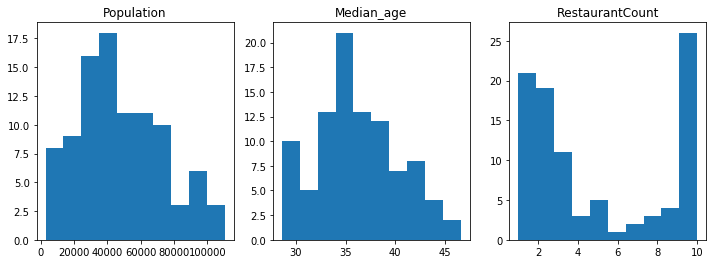

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax0, ax1, ax2 = axes.flat

ax0.hist(df5['Population'])
ax0.set_title('Population')

ax1.hist(df5['Median_age'])
ax1.set_title('Median_age')

ax2.hist(df5['RestaurantCount'])
ax2.set_title('RestaurantCount')

#plt.tight_layout()
plt.show()

Population and median age are fairly uniformly distributed, but Zip Codes tend to have many or few taco restaurants.

#### Correlation

In [30]:
corr_df = df5[['Population', 'Median_age', 'RestaurantCount']].copy()
corr_df.corr()

,Population,Median_age,RestaurantCount
Population,1.000000,-0.118227,-0.160044
Median_age,-0.118227,1.000000,-0.034871
RestaurantCount,-0.160044,-0.034871,1.000000


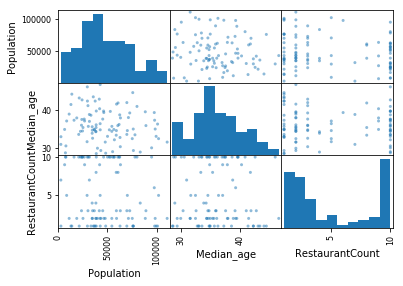

In [31]:
from pandas.plotting import scatter_matrix
scatter_matrix(corr_df)
plt.show()

There is no correlation between any of the items.

#### 3D Scatterplot

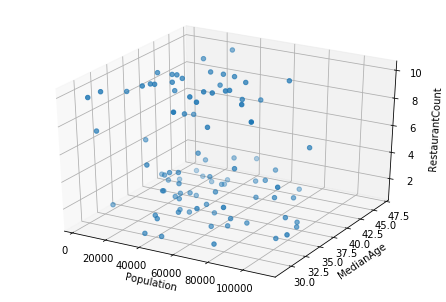

In [32]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df5['Population'], df5['Median_age'], df5['RestaurantCount'])

plt.xlabel('Population')
plt.ylabel('MedianAge')
ax.set_zlabel('RestaurantCount')

pyplot.show()

In [33]:
venue_cat_df = nyc_venues.groupby('Venue Category', axis=0).count()
venue_cat_df = venue_cat_df.drop(['Neighborhood Latitude', 'Neighborhood Longitude','Venue', 'Venue Latitude', 'Venue Longitude'], axis=1)
venue_cat_df = venue_cat_df.rename(index=str, columns={"Neighborhood": "Count"})
#venue_cat_df.set_index('Venue Category')
venue_cat_df.head()

,Count
Venue Category,
American Restaurant,1
BBQ Joint,2
Bakery,3
Bar,23
Beer Garden,3


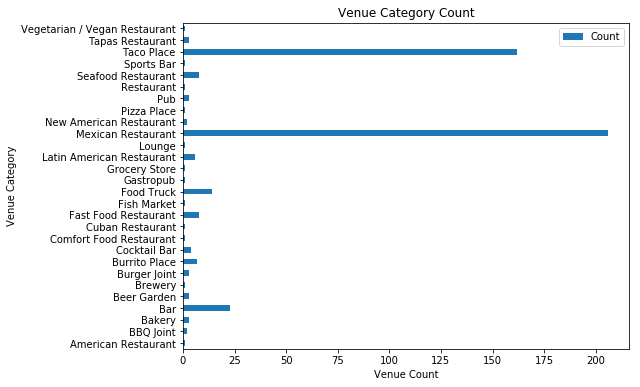

In [34]:
venue_cat_df.plot.barh(figsize=(8, 6))

plt.ylabel('Venue Category') 
plt.xlabel('Venue Count') 
plt.title('Venue Category Count') 
plt.show()

### Cluster Analysis

<p>

In [35]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

#### KNN Clustering

In [36]:
# set number of clusters
kclusters = 5

# create dataframe for cluster modeling and check data types
knn_df = df5[['Population', 'Median_age', 'RestaurantCount']].copy()
knn_df.dtypes

Population           int64
Median_age         float64
RestaurantCount      int64
dtype: object

##### Normalize data

In [37]:
from sklearn.preprocessing import StandardScaler
import numpy as np
X = knn_df.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
#Clus_dataSet

##### Find optimal number of k

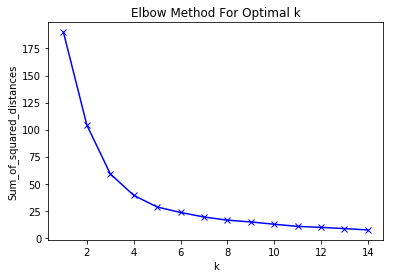

In [38]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Clus_dataSet)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Looks like the optimal number of k is 4

##### Create KNN model

In [39]:
clusterNum = 4
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[0 0 0 0 0 0 2 0 2 0 0 0 3 2 2 0 2 2 2 3 0 0 3 0 0 3 0 0 0 0 3 0 0 3 1 3 1
 1 3 0 3 3 1 1 3 1 1 0 3 3 3 3 0 1 3 3 1 1 1 1 1 1 2 1 3 0 3 0 2 2 0 2 2 0
 0 0 0 1 0 0 2 2 2 2 2 2 2 0 0 0 1 0 0 2 2]


In [40]:
# apply cluster labels to dataframe
df5["Clus_km"] = labels
final_df = df5[['ZipCodes', 'Population', 'Median_age', 'RestaurantCount', 'Clus_km']].copy()

#### Cluster description

In [41]:
final_df.groupby('Clus_km').mean()

,Population,Median_age,RestaurantCount
Clus_km,,,
0,54352.078947,33.431579,2.394737
1,44426.529412,39.517647,9.294118
2,45544.571429,41.014286,1.809524
3,41467.157895,33.268421,9.578947


Looks like Cluster 1 is the best option.

It has the highest population, the second lowest median age and the second to lowest number of taco restaurants.

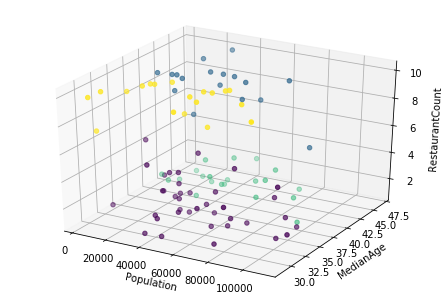

In [42]:
fig = pyplot.figure()
ax = Axes3D(fig)

ax.scatter(df5['Population'], df5['Median_age'], df5['RestaurantCount'],c= labels.astype(np.float))

plt.xlabel('Population')
plt.ylabel('MedianAge')
ax.set_zlabel('RestaurantCount')

pyplot.show()

#### Show best cluster

In [50]:
# Create variable with TRUE if nationality is USA
best_cluster = df5['Clus_km'] == 3

# Select all cases where nationality is USA and age is greater than 50
best_df = df5[best_cluster]
best_df.to_csv()
print('There are {} zip codes in the desired cluster.'.format(best_df.shape[0]))
best_df

There are 19 zip codes in the desired cluster.


,ZipCodes,Neighborhood,LAT,LNG,Population,Median_age,RestaurantCount,Clus_km
12,11238,Central Brooklyn,40.679171,-73.963804,51959,34.8,10,3
19,11201,Northwest Brooklyn,40.693682,-73.989693,56488,34.9,10,3
22,11217,Northwest Brooklyn,40.682306,-73.978099,38567,35.4,8,3
25,11211,Greenpoint,40.712597,-73.953098,94681,30.1,10,3
30,11237,Bushwick and Williamsburg,40.704160,-73.921139,55258,29.1,10,3
33,10001,Chelsea and Clinton,40.750633,-73.997177,22767,34.4,10,3
35,10018,Chelsea and Clinton,40.755319,-73.993114,8062,30.6,10,3
38,10029,East Harlem,40.791763,-73.943970,77857,33.5,10,3
40,10010,Gramercy Park and Murray Hill,40.739065,-73.982255,30708,35.7,10,3
41,10016,Gramercy Park and Murray Hill,40.745224,-73.978297,50112,33.1,10,3


In [51]:
#find geo coordinates of NYC
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinates of New York City are {}, {}.'.format(latitude, longitude))

# create map of New York City using latitude and longitude values
location_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add neighborhood markers to map
for lat, lng, zipcode, neighborhood in zip(best_df['LAT'], best_df['LNG'], best_df['ZipCodes'], best_df['Neighborhood']):
    label = '{}, {}'.format(zipcode, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(location_map)  
    
location_map

### Overlay Subway stops

In [52]:
# Import csv of subway loactions
data = pd.read_csv('subway_locations.csv')
data.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575


In [46]:
map_data = data[['Stop Name', 'GTFS Latitude', 'GTFS Longitude']].copy()

In [54]:
from folium.plugins import HeatMap

hm_lat = 40.7128
hm_lat = 74.0060

nyc_latitude = map_data['GTFS Latitude'].values[0]  
nyc_longitude = map_data['GTFS Longitude'].values[0]

subway_heatmap = folium.Map(location=[nyc_latitude, nyc_longitude], zoom_start=11)

# List comprehension to make out list of lists of Crime Loatitude and Longitude
heat_data = [[row['GTFS Latitude'], 
              row['GTFS Longitude']] for index, row in map_data.iterrows()]

# Plot the crimes on the map
HeatMap(heat_data,
        min_opacity=40,
        max_zoom=18, 
        max_val=1.0, 
        radius=15,
        blur=29,
        gradient=None,
        overlay=True).add_to(subway_heatmap)

# add neighborhood markers to map
for lat, lng, zipcode, neighborhood in zip(best_df['LAT'], best_df['LNG'], best_df['ZipCodes'], best_df['Neighborhood']):
    label = '{}, {}'.format(zipcode, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(subway_heatmap)  

subway_heatmap

## Results

<p>Cluster 1 appears to provide the best zip codes matching my initial hypotheses – this provides a list of 19 zip codes spread out over 11 neighborhoods.</p>
<p>To narrow down even further - overlaying the density of subway stops over the map.</p> 
<p>Lower Manhattan and Northwest and Central Brooklyn are two groups of zip codes prioritized for further exploration.</p> 


## Discussion

<p><strong>Limitations</strong></p>
<p>I faced many limitations that could affect this analysis. Because of the Foursquare API I could only limit the number of locations per zip code to 10 before using all my allotted calls from the service. I also only used subway locations – it is possible there are better public transportation modes I should consider such as bus stops and bike share locations.</p>
<p>With those considerations, I am still happy with my analysis as</p>

<p><strong>Further Study Needed</strong></p>
<ul>
<li>Does competition help or hurt? My hypothesis is that nearby taco places will help my profitability, but further study might show that being the only nearby taco restaurant is better for business.</li>
<li>How does concentration of complimentary venues – or venues likely to be visited next after eating at a taco restaurant – contribute to the success of a restaurant?</li>
<li>My analysis only contained subway stops – there are also buses and bikeshares available. Does including these additional modes of transportation change my results?</li>
<li>Once I select a location – can I use Foursquare API to mine further data about features and attributes of well liked restaurants in the location?</li>
</ul>

## Conclusion